In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
from arch.compat.numba import jit
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import scipy.stats as ss
from arch import arch_model
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use("bmh")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to)
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

In [3]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().dropna()

In [4]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    if True:
        return 0 # fixme
    return market.cov(single_stock, lag) / market.std(ddof=lag)

In [5]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean, lags=lag, # mean = Constant, ARX, HARX + the number of lags
                       vol=vol, p=p, o=o, q=q, # vol = Garch, EGARCH, HARCH + the number of lags
                       dist=dist) # dist = Normal, t, skewstudent, ged

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0])
    vars = pd.Series(forecast.variance.tail(1).to_numpy()[0])
    return stand_residuals, means, vars

In [6]:
DATE_FROM = '2015-01-01'
DATE_TO = '2017-12-31'
tickers = ['TSLA', 'AAPL', 'IBM', 'AMZN', 'MMM',
           'ABMD', 'ACN', 'APD', 'GOOGL', 'BLK']

In [7]:
BETA_LAG = 252
GARCH_LAG = 200
CORRELATION_MATRIX_LAG = 200
GARCH_REFIT_DELAY_DAYS = 30

In [8]:
spy_p = raw_adj_close_prices('SPY', DATE_FROM, DATE_TO)

raw_prices = []
for i in range(0, len(tickers)):
    raw_prices.append(raw_adj_close_prices(tickers[i], DATE_FROM, DATE_TO))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


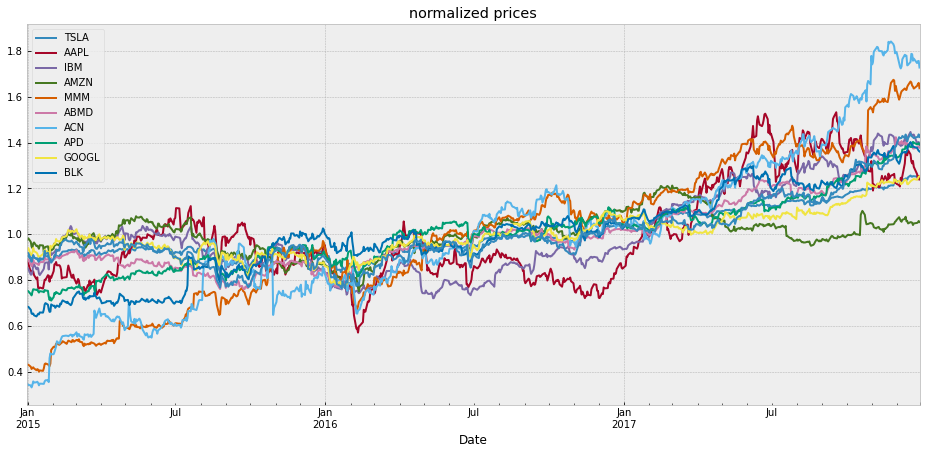

In [9]:
plt.figure(figsize=(16,7))
(spy_p / spy_p.mean()).plot()
for data in raw_prices:
    (data / data.mean()).plot()
plt.title("normalized prices")
plt.legend(tickers)
plt.show()

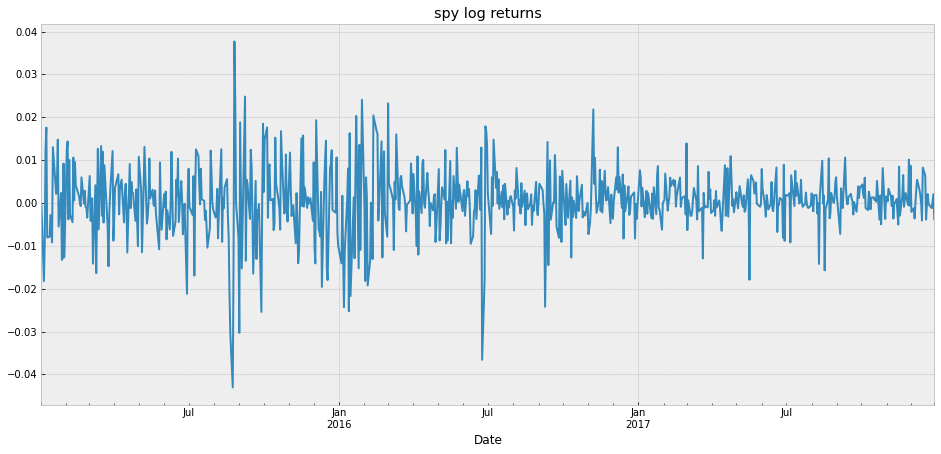

In [10]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


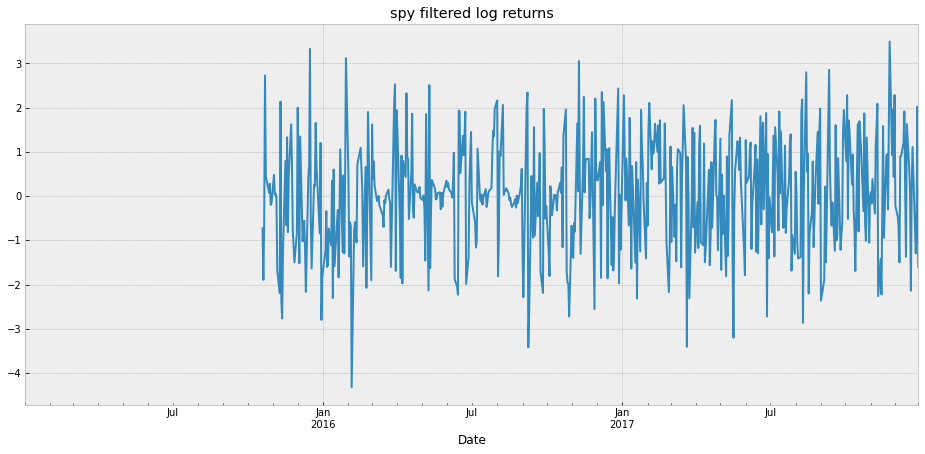

In [11]:
spyf, spy_means, spy_vars = arch_filtered_series(spy)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

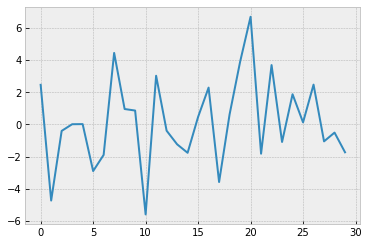

In [12]:
spy_means.plot()
plt.show()

<Figure size 1152x504 with 0 Axes>

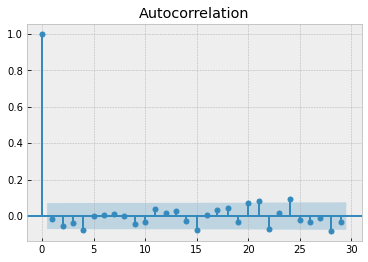

In [13]:
plt.figure(figsize=(16,7))
plot_acf(spy)
plt.show()


<Figure size 1152x504 with 0 Axes>

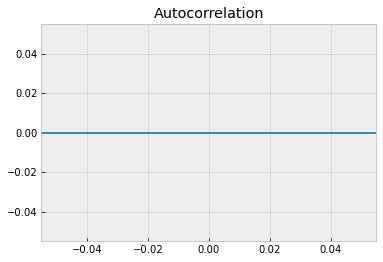

In [14]:
plt.figure(figsize=(16,7))
plot_acf(spyf)
plt.show()

In [15]:
res = spy_p.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spy.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spyf.dropna().values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.354182
p-value: 0.979698
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -15.784424
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -23.119264
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [16]:
# betas = {}
# for ticker, data in raw_prices.items():
#     betas[ticker] = beta(spy_p, data)
#
# betas

In [17]:
# net_market = raw_adj_close_log_returns(raw_prices['TSLA']) - spy * betas['TSLA']
# plt.figure(figsize=(16,7))
# net_market.plot()
# plt.show()

In [18]:
# teslaf, _ = arch_filtered_series(net_market)
# plt.figure(figsize=(16,7))
# teslaf.plot()
# plt.title("tsla filtered log returns")
# plt.show()

In [19]:
# res = net_market.values
# result = adfuller(res)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))
#
# res = teslaf.dropna().values
# result = adfuller(res)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))
#

In [20]:
series, means, vars = arch_filtered_series(spy)

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [21]:
mkt_returns = []
for i in range(0, len(raw_prices)):
    ticker = tickers[i]
    data = raw_prices[i]
    mkt_returns.append(raw_adj_close_log_returns(data))

betas = []
for i in range(0, len(mkt_returns)):
    ticker = tickers[i]
    data = mkt_returns[i]
    betas.append(beta(spy, data))

net_market_returns = []
for i in range(0, len(mkt_returns)):
    ticker = tickers[i]
    data = mkt_returns[i]
    net_market_returns.append(data - spy * betas[i])

In [22]:
net_market_returns_f = []
means = []
vars = []
for i in range(0, len(net_market_returns)):
    ticker = tickers[i]
    net_rets = net_market_returns[i]
    fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets)
    net_market_returns_f.append(fltr_res)
    means.append(fcst_means.dropna())
    vars.append(fcst_vars.dropna())

net_market_returns_f


C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


[Date
 2015-01-02         NaN
 2015-01-05         NaN
 2015-01-06         NaN
 2015-01-07         NaN
 2015-01-08         NaN
                 ...   
 2017-12-22   -1.404300
 2017-12-26   -0.622780
 2017-12-27    0.429084
 2017-12-28    1.779884
 2017-12-29   -0.421142
 Freq: D, Length: 755, dtype: float64,
 Date
 2015-01-02         NaN
 2015-01-05         NaN
 2015-01-06         NaN
 2015-01-07         NaN
 2015-01-08         NaN
                 ...   
 2017-12-22   -1.290560
 2017-12-26   -1.264482
 2017-12-27    1.108015
 2017-12-28    0.421446
 2017-12-29   -0.925666
 Freq: D, Length: 755, dtype: float64,
 Date
 2015-01-02         NaN
 2015-01-05         NaN
 2015-01-06         NaN
 2015-01-07         NaN
 2015-01-08         NaN
                 ...   
 2017-12-22    0.042403
 2017-12-26    0.071196
 2017-12-27   -0.431594
 2017-12-28   -0.426163
 2017-12-29   -0.672995
 Freq: D, Length: 755, dtype: float64,
 Date
 2015-01-02         NaN
 2015-01-05         NaN
 2015-01-06        

In [23]:
returns = {}
for i in range(0, len(tickers)):
    returns[tickers[i]] = net_market_returns_f[i].dropna()

data = pd.DataFrame(returns, columns=tickers)

In [24]:
data

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2015-10-19,-1.094344,-0.402109,-0.485576,2.547382,-0.482332,0.654540,-0.350948,-1.546752,1.248033,-0.736242
2015-10-20,-3.041855,1.742372,-4.632037,0.141018,1.334070,-0.755376,-0.395201,-0.265340,-1.151781,-1.275501
2015-10-21,-0.578744,-1.660310,0.587211,0.848986,1.206756,-2.101987,-1.063288,-0.366044,-1.648696,-1.386854
2015-10-22,0.760487,1.705569,1.071442,0.807571,2.638944,-2.446715,3.061576,1.278330,0.745657,1.710381
2015-10-23,0.488210,1.483710,-0.140217,1.921767,0.685384,0.698005,1.244303,-0.692505,1.310705,0.853793
...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-1.404300,-1.290560,0.042403,-1.204453,-1.145934,-1.618293,-0.247011,-0.629052,-1.592487,0.520444
2017-12-26,-0.622780,-1.264482,0.071196,1.999149,-0.881618,-0.305223,-1.762928,-1.278089,0.020040,-0.615865
2017-12-27,0.429084,1.108015,-0.431594,-0.923845,0.247622,-1.680372,0.398267,0.470053,-0.221596,1.247364


In [25]:
corr_matrix = data.corr(min_periods=200)
corr_matrix

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
TSLA,1.000000,0.087812,0.104051,0.139820,0.012227,0.120208,0.161396,0.081539,0.079787,0.089008
AAPL,0.087812,1.000000,0.083836,0.184717,0.142825,0.206569,0.129716,0.131551,0.253018,0.138246
IBM,0.104051,0.083836,1.000000,0.026649,0.200724,0.039736,0.262194,0.170263,0.073187,0.211352
AMZN,0.139820,0.184717,0.026649,1.000000,0.060135,0.063871,0.175252,0.079600,0.252758,0.064704
MMM,0.012227,0.142825,0.200724,0.060135,1.000000,0.140486,0.196659,0.236770,0.172790,0.205082
ABMD,0.120208,0.206569,0.039736,0.063871,0.140486,1.000000,0.130753,0.052948,0.107086,0.118161
ACN,0.161396,0.129716,0.262194,0.175252,0.196659,0.130753,1.000000,0.262140,0.279359,0.276412
APD,0.081539,0.131551,0.170263,0.079600,0.236770,0.052948,0.262140,1.000000,0.147192,0.194480
GOOGL,0.079787,0.253018,0.073187,0.252758,0.172790,0.107086,0.279359,0.147192,1.000000,0.136492
BLK,0.089008,0.138246,0.211352,0.064704,0.205082,0.118161,0.276412,0.194480,0.136492,1.000000


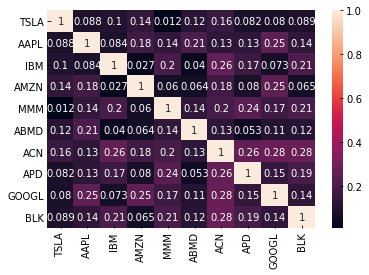

In [26]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [27]:
corr_matrix.iloc[0]


TSLA     1.000000
AAPL     0.087812
IBM      0.104051
AMZN     0.139820
MMM      0.012227
ABMD     0.120208
ACN      0.161396
APD      0.081539
GOOGL    0.079787
BLK      0.089008
Name: TSLA, dtype: float64

In [28]:
def remove_row_and_column(matrix, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

In [29]:
mus = [] ### fixme: move to indicies
for i in range(0, len(tickers)):
    r_j_j = remove_row_and_column(corr_matrix, i)
    inv_r_j_j = np.linalg.inv(r_j_j)
    mu_j = np.delete(means, i)
    sigma_j = np.delete(vars, i)
    v = (real_returns - mu_j) / sigma_j
    mus.append(means[i][0] + vars[i][0] * corr_matrix[i].dot(inv_r_j_j).dot(v))

ValueError: Shape of passed values is (9, 10), indices imply (10, 10)

In [ ]:
def alpha(mu, real_return):
    return 2 * mu - real_return